# Multi-Gaussian example

As an introductory example we can use astroABC to find the posterior distribution for some Gaussian distributed data. Although in this case we already know the likelihood this example is to illustrate how to call astroABC and provide user-defined metrics.


In [41]:
import sys
sys.path.insert(0, '..')
# start by importing astroabc and numpy
import numpy as np
import astroabc
import seaborn as sns
import matplotlib.pyplot as plt
import corner

We need to provide:

- a dataset
- a forwards simulating model for the data
- a method defining the distance metric.

For this example we generate a dataset of a 1000 draws from a 2D multi-Gaussian where the true means are e.g

$\mu_{1,true} = 0.037579, \, \mu_{2, true}=0.573537$

and we have fixed the covariance matrix to be  a diagonal matrix with $\sigma_1^2 = \sigma_2^2 = 0.05$. 
We can do this using an inbuilt model class in astroabc.

In [2]:
#make the fake data with diagonal covariance
means= np.array([0.037579, 0.573537])
cov =np.array([0.01,0.005,0.005,0.1])
data = astroabc.Model("normal",1000).make_mock(means,cov)

In this example the make_mock method also provides a forwards simulating model for the data. 

In [3]:
#define a method for simulating the data given input parameters
def simulation(param, pool=None):
    cov =np.array([0.01,0.005,0.005,0.1])
    #Ideally do something with the pool here
    return astroabc.Model("normal",10000).make_mock(param,cov)

model_sim = simulation

Next we define a distance metric method. In this example instead of using all of the data (all 1000 draws from a 2D Gaussian) we use the means of the data as a summary statistic and our distance metric is the sum over the difference in the means for the 2D Gaussian 

In [4]:
def dist_metric(d,x):
    return np.sum(np.abs(np.mean(x,axis=0) - np.mean(d,axis=0)))

Next we specify priors for each of the parameters we want to vary in the sampler. This is done by specifying a list of tuples. The zeroth element in each tuple should be a string specifying the prior for this parameter and the first element should be a list of the hyperparameters needed for this prior.
e.g. below we use a normal distribution with mean  0 and variance 0.5 for the first parameter and a uniform distribution from 0.1 - 0.9 for the second parameter.

In [5]:
priors =  [('normal', [0.03,0.1]), ('uniform', [0.1, 0.9])]

Next we need to set some keywords for astroABC. This can be done by creating a dictionary of inputs which are passed to the sampler. Many of these entries have defaults and do not need to be specified explicitly.
Only the name of the distance metric method needs to be explicity provided as a keyword.
The full set of keywords are given in the doc string of the class. Some examples are

- tol_type: which specifies the decreasing tolerance levels. "exp","lin", "log" and "const" are options. (default = 'exp')

- verbose: level of verbosity, 0 = no printout to screen, 1 = print to screen  (default = 0)

- adapt_t: Boolean True/False for adaptive threshold setting (default = False)

- threshold: qth quantile used in adaptive threshold setting (default = 75)

- pert_kernel: 1 =component wise pert. with local diag variance; 2 = multivariate pert. based on local covariance

- variance_method: 0 =weighted covariance, 1= Filippi, 2 = TVZ, 3= Leodoit_Wolf, 4=k-nn (default = 0)

- dfunc:method for calculating the distance metric

- from_restart: Boolean True/False

- restart: string name of restart file

- outfile:string specifying name of output file (default = abc_out.txt)

- mpi: Boolean True/False (default = False)

- mp:Boolean True/False (default = False)

- num_proc:number of threads for mp setting (default = None)

Please see the doc strings of the astroABC sampler for details on each of these settings.

In [6]:
prop={'dfunc':dist_metric, 'outfile':"gaussian_example.txt", 'verbose':1, 'adapt_t': True, 'pert_kernel':2}

Now we are ready to create an instance of our sampler. 
To do this we just need to specify the following to the astroabc.ABC_class

astroabc.ABC_class(number of parameters,number of particles,data,tolerance levels,number of iterations,priors,prop)

To begin let's run in serial using 100 particles for 30 iterations with default tolerance levels of a maximum threshold of 0.7 and  a minimum threshold of 0.05:

In [7]:
# nparam,npart,data,tlevels,niter,priors
sampler = astroabc.ABC_class(2, 100, data, [0.5,0.002], 20, priors,**prop)

	 	
	 ########################     astroABC     ########################	
	 	
	 Npart=100 	 numt=20 	 tol=[0.5000,0.0020] exp
	 Priors= [('normal', [0.03, 0.1]), ('uniform', [0.1, 0.9])]


Then we simply begin sampling on our data...

In [8]:
sampler.sample(model_sim)

	 Step: 0 	 tol: 0.5 	 Params: [0.020522396763154486, 0.5263688944267011]
	 Step: 1 	 tol: 0.3742181495572509 	 Params: [0.03709637825806263, 0.5703979560627366]
	 Step: 2 	 tol: 0.2965377436432852 	 Params: [0.03701018266143877, 0.5659714547188062]
	 Step: 3 	 tol: 0.2370191959974505 	 Params: [0.028563201676633985, 0.556070736422599]
	 Step: 4 	 tol: 0.20933307897674305 	 Params: [0.03872276678510157, 0.5582240748029592]
	 Step: 5 	 tol: 0.17228427085279782 	 Params: [0.05062724671056203, 0.5646824462206771]
	 Step: 6 	 tol: 0.14911549143593772 	 Params: [0.032962942638231914, 0.553216934777209]
	 Step: 7 	 tol: 0.12280751557771218 	 Params: [0.034037688464927746, 0.5545406888236522]
	 Step: 8 	 tol: 0.10655523222636654 	 Params: [0.0476472016831335, 0.5616191752831307]
	 Step: 9 	 tol: 0.08590238305730193 	 Params: [0.04937789930246498, 0.5621936022612837]
	 Step: 10 	 tol: 0.06519143005414267 	 Params: [0.0429046405942997, 0.5616656407061443]
	 Step: 11 	 tol: 0.05231471744230793 	

In [24]:
samples = np.array(sampler.samples)
samples

array([[0.0205224 , 0.52636889],
       [0.03709638, 0.57039796],
       [0.03701018, 0.56597145],
       [0.0285632 , 0.55607074],
       [0.03872277, 0.55822407],
       [0.05062725, 0.56468245],
       [0.03296294, 0.55321693],
       [0.03403769, 0.55454069],
       [0.0476472 , 0.56161918],
       [0.0493779 , 0.5621936 ],
       [0.04290464, 0.56166564],
       [0.03962307, 0.5647663 ],
       [0.03649375, 0.56387288],
       [0.0371813 , 0.5633386 ],
       [0.037978  , 0.56364317],
       [0.03756461, 0.56147125],
       [0.03860575, 0.56232138],
       [0.03906409, 0.56230395],
       [0.03926019, 0.56179119],
       [0.03899238, 0.56191759]])

In [27]:
samples[:,0]

array([0.0205224 , 0.03709638, 0.03701018, 0.0285632 , 0.03872277,
       0.05062725, 0.03296294, 0.03403769, 0.0476472 , 0.0493779 ,
       0.04290464, 0.03962307, 0.03649375, 0.0371813 , 0.037978  ,
       0.03756461, 0.03860575, 0.03906409, 0.03926019, 0.03899238])

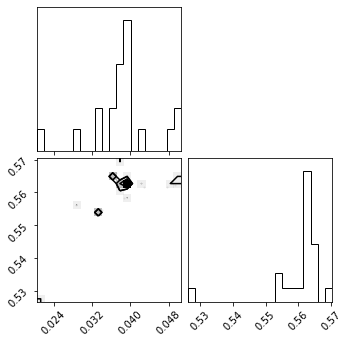

In [42]:
corner.corner(samples)
plt.show()

/home/isidro/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


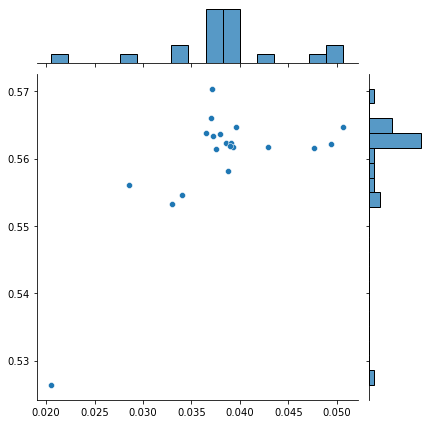

In [37]:
sns.jointplot(samples[:,0], samples[:,1])

The output above shows the estimated means of the 2D Gaussian averaged over all 100 particles at each iteration, together with the tolerance level. Note above that the sampling may end before 20 iterations if the minimum tolerance level is reached first.
Recall that the true parameter values are $\mu_{1,true} = 0.037579, \, \mu_{2, true}=0.573537$

# K-Nearest Neighbours estimation for data sample with covariance matrix

We could also have created a dataset with a full covariance matrix using 

In [ ]:
means= np.array([0.7579, 0.273537])
cov = np.array([0.1,0.01,0.01,0.1])
data_cov = astroabc.Model("normal",1000).make_mock(means,cov)

Keeping model simulation and distance methods the same as above. We can select a different way of estimating the covariance amongst all the particles using k-nearest neighbours. This returns a local covariance estimate and in many cases this reaches convergence faster then using a weighted covariance amongst all particles.

In [ ]:
priors =  [('uniform', [0.1,0.9]), ('uniform', [0.1, 0.9])]
prop={'dfunc':dist_metric, 'outfile':"gaussian_example.txt", 'verbose':1, \
      'adapt_t': True, 'variance_method':4, 'k_near':10 }

In [ ]:
sampler = astroabc.ABC_class(2,100,data_cov,[0.5,0.002],25,priors,**prop)

In [ ]:
sampler.sample(model_sim)